# Palestine Refugee Analysis

In this notebook we analyze where refugees in Israel and Palestine head to during 2023-2024

## Where did people in Israel and Palestine head to during 2023-2024?

In [2]:
import neo4j

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

In [3]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [4]:
session = driver.session(database="neo4j")

In [5]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [6]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [7]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

# Loading Data into Neo4j

Data info

|variable          |class     |description       |
|:-----------------|:---------|:-----------------|
|year              |double    |The year.              |
|coo_name          |character |Country of origin name.        |
|coo               |character |Country of origin UNHCR code.   |
|coo_iso           |character |Country of origin ISO code.  |
|coa_name          |character |Country of asylum name.    |
|coa               |character |Country of asylum UNHCR code.  |
|coa_iso           |character |Country of asylum ISO code.    |
|refugees          |double    |The number of refugees.   |
|asylum_seekers    |double    |The number of asylum-seekers.  |
|returned_refugees |double    |The number of returned refugees. |
|idps              |double    |The number of internally displaced persons.     |
|returned_idps     |double    |The number of returned internally displaced persons.  |
|stateless         |double    |The number of stateless persons.  |
|ooc               |double    |The number of others of concern to UNHCR.   |
|oip               |double    |The number of other people in need of international protection.     |
|hst               |double    |The number of host community members.     |

In [8]:
def create_graph(year, refugee_min=1):
    """
    Loads CSV file for a specific year (files named populationXXXX.csv).
    refugee_min = lower limit of refugees to include (default 1)
    """
    my_neo4j_wipe_out_database()

    query = f"""
        LOAD CSV WITH HEADERS FROM 'file:///population{year}.csv' AS row
        MERGE (origin:Country {{iso_code: row.coo_iso, name: row.coo_name}})
        MERGE (asylum:Country {{iso_code: row.coa_iso, name: row.coa_name}})

        WITH row, origin, asylum
        WHERE toInteger(row.refugees) >= {refugee_min}
        CREATE (origin)-[:REFUGEE_FLOW {{
            year: toInteger(row.year),
            refugees: toInteger(row.refugees),
            asylum_seekers: toInteger(row.asylum_seekers),
            idps: toInteger(row.idps)
        }}]->(asylum)
        """

    session.run(query)

In [9]:
create_graph(2023, refugee_min=1)

In [10]:
# query for Israel

query = """

MATCH (n)-[r]->(b)
WHERE n.name CONTAINS 'Israel'
RETURN n.name AS origin_name, 
       n.iso_code AS origin_iso_code,
       toInteger(r.refugees) AS num_refugees, 
       toInteger(r.asylum_seekers) AS num_asylum_seekers,
       b.name AS asylum_name,
       b.iso_code AS asylum_iso_code

ORDER BY num_refugees DESC
LIMIT 20

"""

my_neo4j_run_query_pandas(query)

,origin_name,origin_iso_code,num_refugees,num_asylum_seekers,asylum_name,asylum_iso_code
0,Israel,ISR,163,77,Germany,DEU
1,Israel,ISR,121,60,United Kingdom of Great Britain and Northern I...,GBR
2,Israel,ISR,104,744,United States of America,USA
3,Israel,ISR,77,10,Spain,ESP
4,Israel,ISR,73,5,Poland,POL
5,Israel,ISR,62,81,Canada,CAN
6,Israel,ISR,51,5,Romania,ROU
7,Israel,ISR,33,6,Portugal,PRT
8,Israel,ISR,20,17,Sweden,SWE
9,Israel,ISR,18,15,Ireland,IRL


In [11]:
# query for Palestine 
query = """

MATCH (n)-[r]->(b)
WHERE n.name CONTAINS 'Pales'
RETURN n.name AS origin_name, 
       n.iso_code AS origin_iso_code,
       toInteger(r.refugees) AS num_refugees, 
       toInteger(r.asylum_seekers) AS num_asylum_seekers,
       b.name AS asylum_name,
       b.iso_code AS asylum_iso_code

ORDER BY num_refugees DESC
LIMIT 20

"""

my_neo4j_run_query_pandas(query)

,origin_name,origin_iso_code,num_refugees,num_asylum_seekers,asylum_name,asylum_iso_code
0,Palestinian,PSE,13988,1277,Greece,GRC
1,Palestinian,PSE,6461,155,Iraq,IRQ
2,Palestinian,PSE,5538,4795,Belgium,BEL
3,Palestinian,PSE,2407,250,Cyprus,CYP
4,Palestinian,PSE,2211,115,France,FRA
5,Palestinian,PSE,2142,1849,Germany,DEU
6,Palestinian,PSE,1336,171,Sweden,SWE
7,Palestinian,PSE,1234,260,Spain,ESP
8,Palestinian,PSE,876,327,United Kingdom of Great Britain and Northern I...,GBR
9,Palestinian,PSE,826,117,Italy,ITA


# PageRank

Running the PageRank algorithm. For more detail, see the data_science_graph_algos Python notebook.

Note the direction meanings:
- natural: origin --> asylum || a country gains pagerank if it receives refugees from important origins
- reverse: asylum --> origin || a country gains pagerank if it "voted for" by important asylums

In [12]:
def analyze_refugee_pagerank(year, refugee_min=1, direction='natural', 
                             damping=0.85, maxIterations=100):
    """
    Analyze refugee flow with pagerank for a specific year with configurable direction
    Parameters:
    - year: Dataset year to analyze
    - refugee_min: Minimum refugee count to include (default 1)
    - direction: 'natural' (origin->asylum) or 'reverse' (asylum->origin)
    - 
    Returns: pandas dataframe w/ pagerank results
    """
    create_graph(year, refugee_min=refugee_min)
    session.run("CALL gds.graph.drop('pagerank_graph', false) YIELD graphName")
    
    # Project graph with specified direction
    orientation = 'NATURAL' if direction.lower() == 'natural' else 'REVERSE'
    project_query = f"""
    CALL gds.graph.project(
        'pagerank_graph',
        'Country',
        {{REFUGEE_FLOW: {{
            orientation: '{orientation}',
            properties: 'refugees'
        }}}}
    )
    """
    session.run(project_query)
    
    #pagerank w/ refugee counts as weights
    pagerank_query = f"""
    CALL gds.pageRank.stream('pagerank_graph', {{
        maxIterations: {maxIterations},
        dampingFactor: {damping},
        relationshipWeightProperty: 'refugees'
    }})
    YIELD nodeId, score
    RETURN 
        gds.util.asNode(nodeId).name AS country,
        gds.util.asNode(nodeId).iso_code as iso_code,
        score AS pagerank_score
    ORDER BY pagerank_score DESC
    """
    return my_neo4j_run_query_pandas(pagerank_query)

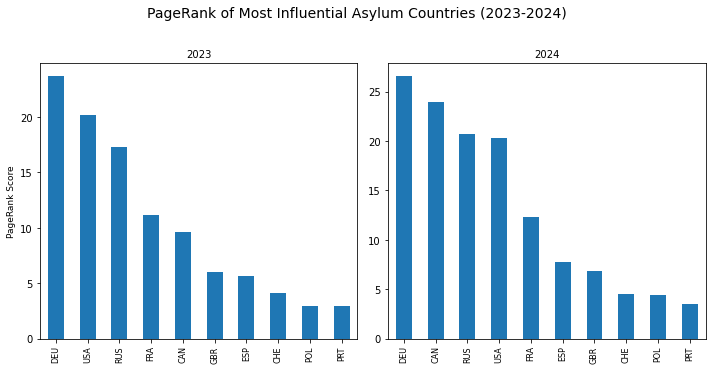

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('PageRank of Most Influential Asylum Countries (2023-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

axes = axes.flatten()

for idx, year in enumerate(range(2023, 2025)):
    ax = axes[idx]
    
    df = analyze_refugee_pagerank(year, direction='natural')
    top_10 = df[:10]
    
    top_10.plot.bar(x='iso_code', y='pagerank_score', ax=ax, legend=False)
    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')
    
    # onlyadd ylabel to first
    if idx % 4 == 0:
        ax.set_ylabel("PageRank Score", fontsize=9)

for idx in range(len(range(2023, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Interpretation**

We see here that the countries that Israelian immigrants sought (Germany, GBR, USA) are within the countries that were most influential asylum countries while those that Palestanians sought were not (Greece, Iraq, Belgium, etc). 

This may be due to political reasons or due to discrepancies in channels for immigration accessible to immigrants.

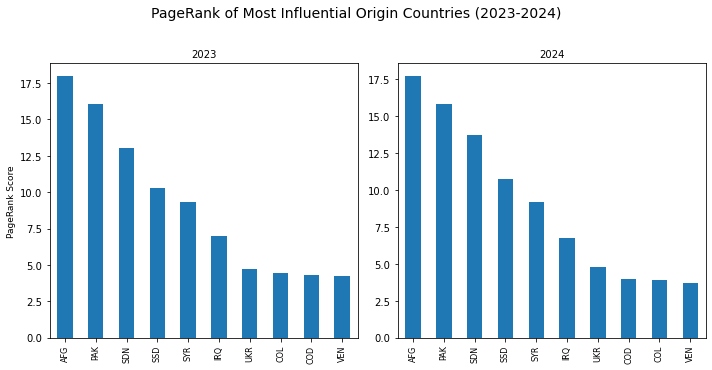

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('PageRank of Most Influential Origin Countries (2023-2024)', y=1.02, fontsize=14)
plt.subplots_adjust(hspace=0.5, wspace=0.3)

axes = axes.flatten()

for idx, year in enumerate(range(2023, 2025)):
    ax = axes[idx]
    
    df = analyze_refugee_pagerank(year, direction='reverse')
    top_10 = df[:10]
    
    top_10.plot.bar(x='iso_code', y='pagerank_score', ax=ax, legend=False)
    ax.set_title(f'{year}', fontsize=10)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_xlabel('')
    
    # onlyadd ylabel to first
    if idx % 4 == 0:
        ax.set_ylabel("PageRank Score", fontsize=9)

for idx in range(len(range(2023, 2025)), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Rather than Israeli / Palestinian immigrants being the majority, we see Afghanistan and Pakistan as one of the top influential countries during both 2023 and 2024. This may reflect the ongoing clashes between these two countries -- while being reported to be started from 2024, the data here shows that the conflict may have been a long rooted issue between the countries that resulted in unstability within the countries. 

We confirm here that Israelian and Palestinian immigrants do not comprise the majority of the immigrants during the timeframe (2023 - 2024).

## Let's investigate the countries that immigrants due to Gaza War head to

In [14]:
df_2023 = pd.read_csv("data/population2023.csv")
df_2024 = pd.read_csv("data/population2024.csv")

cols = ['year', 'coo_name', 'coo', 'coo_iso',
        'coa_name', 'coa', 'coa_iso', 'refugees']
df_2023 = df_2023[cols]
df_2024 = df_2024[cols]

df_2023.sort_values(by='refugees', ascending=False, inplace=True)
df_2024.sort_values(by='refugees', ascending=False, inplace=True)

df_2023_isr = df_2023[df_2023['coo_iso']=="ISR"]
df_2023_pse = df_2023[df_2023['coo_iso']=="PSE"]

df_2024_isr = df_2024[df_2024['coo_iso']=="ISR"]
df_2024_pse = df_2024[df_2024['coo_iso']=="PSE"]


In [15]:
#pagerank for 2015, 2016
pagerank_2023 = analyze_refugee_pagerank(2023, direction='natural')
pagerank_2024 = analyze_refugee_pagerank(2024, direction='natural')

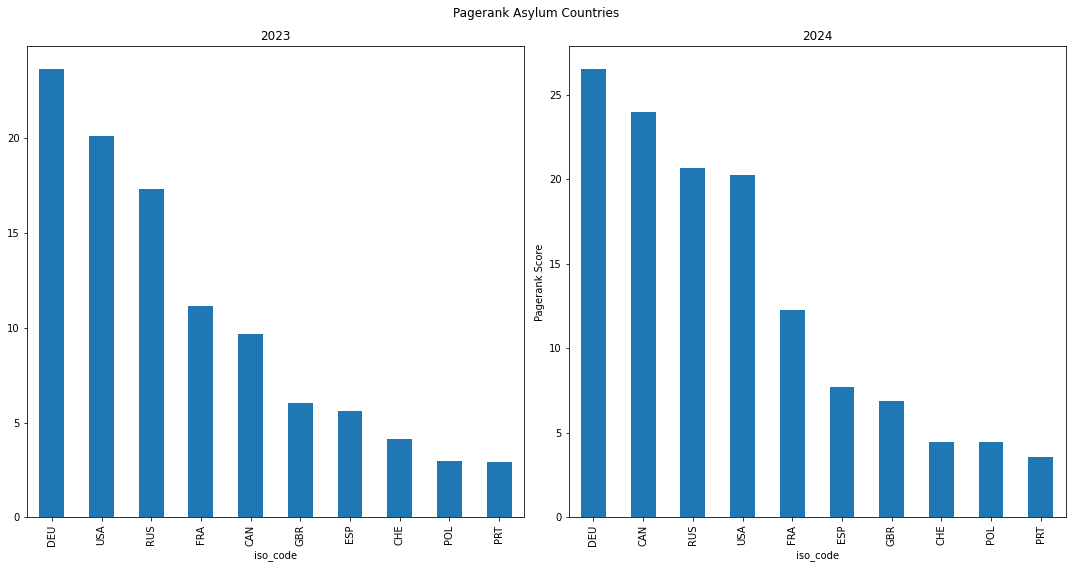

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15,8))
pagerank_2023[:10].plot.bar(x='iso_code', y='pagerank_score', ax=axes[0], legend=False)
pagerank_2024[:10].plot.bar(x='iso_code', y='pagerank_score', ax=axes[1], legend=False)
axes[0].set_title('2023')
axes[1].set_title('2024')
plt.ylabel('Pagerank Score')
plt.suptitle("Pagerank Asylum Countries")
plt.tight_layout()
plt.show()


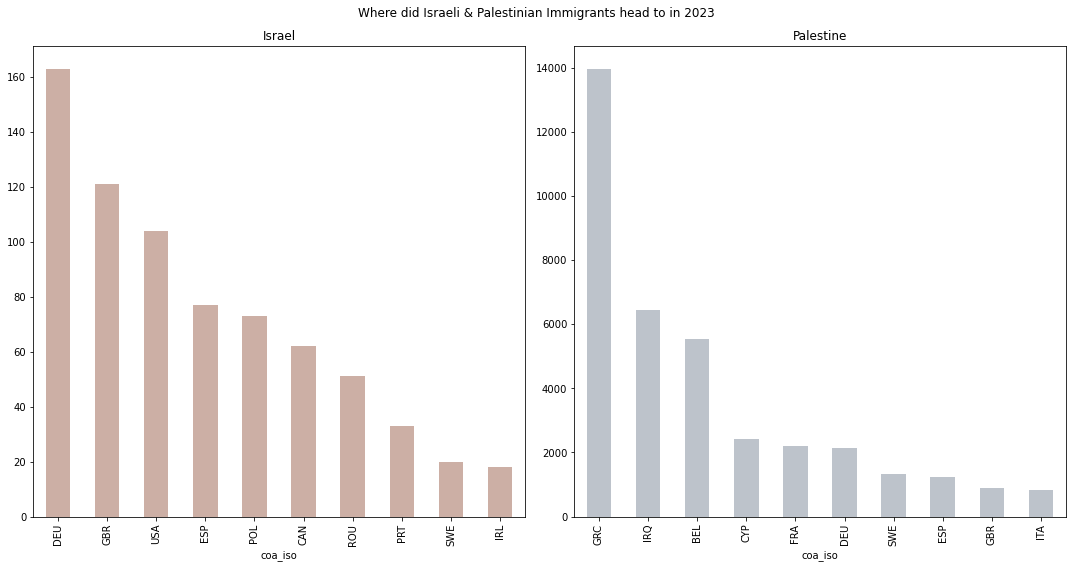

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
df_2023_isr[:10].plot.bar(x='coa_iso', y='refugees', ax=axes[0], legend=False, color = "#CCAFA5")
df_2023_pse[:10].plot.bar(x='coa_iso', y='refugees', ax=axes[1], legend=False, color = "#BDC3CB")
axes[0].set_title("Israel")
axes[1].set_title("Palestine")
plt.suptitle("Where did Israeli & Palestinian Immigrants head to in 2023")
plt.tight_layout()
plt.show()

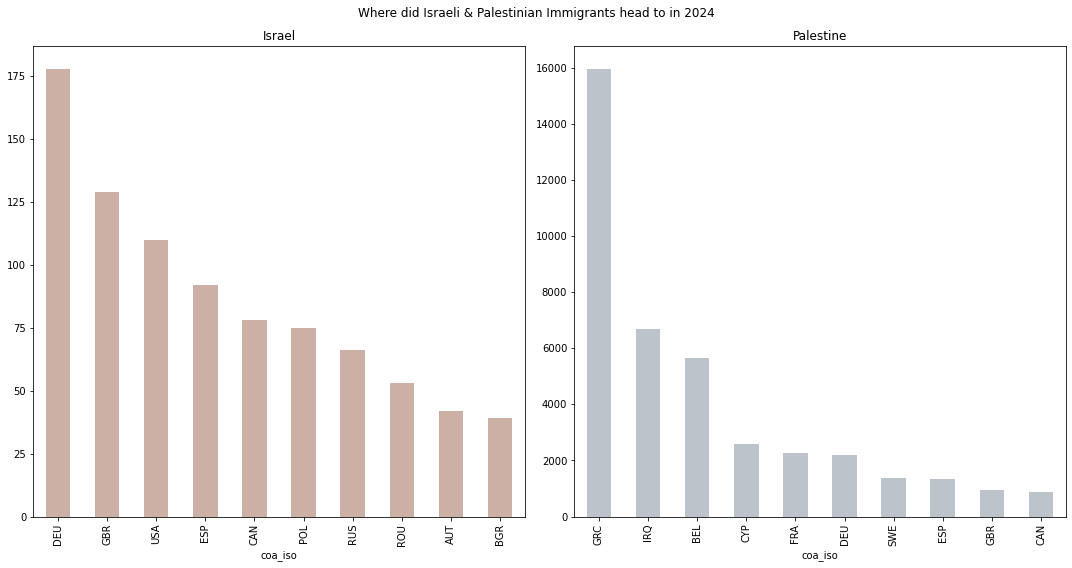

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
df_2024_isr[:10].plot.bar(x='coa_iso', y='refugees', ax=axes[0], legend=False, color = "#CCAFA5")
df_2024_pse[:10].plot.bar(x='coa_iso', y='refugees', ax=axes[1], legend=False, color = "#BDC3CB")
axes[0].set_title("Israel")
axes[1].set_title("Palestine")
plt.suptitle("Where did Israeli & Palestinian Immigrants head to in 2024")
plt.tight_layout()
plt.show()

**Note**

The countries that immigrants headed to are almost the same, but the numbers of immigrants have increased compared to 2023.

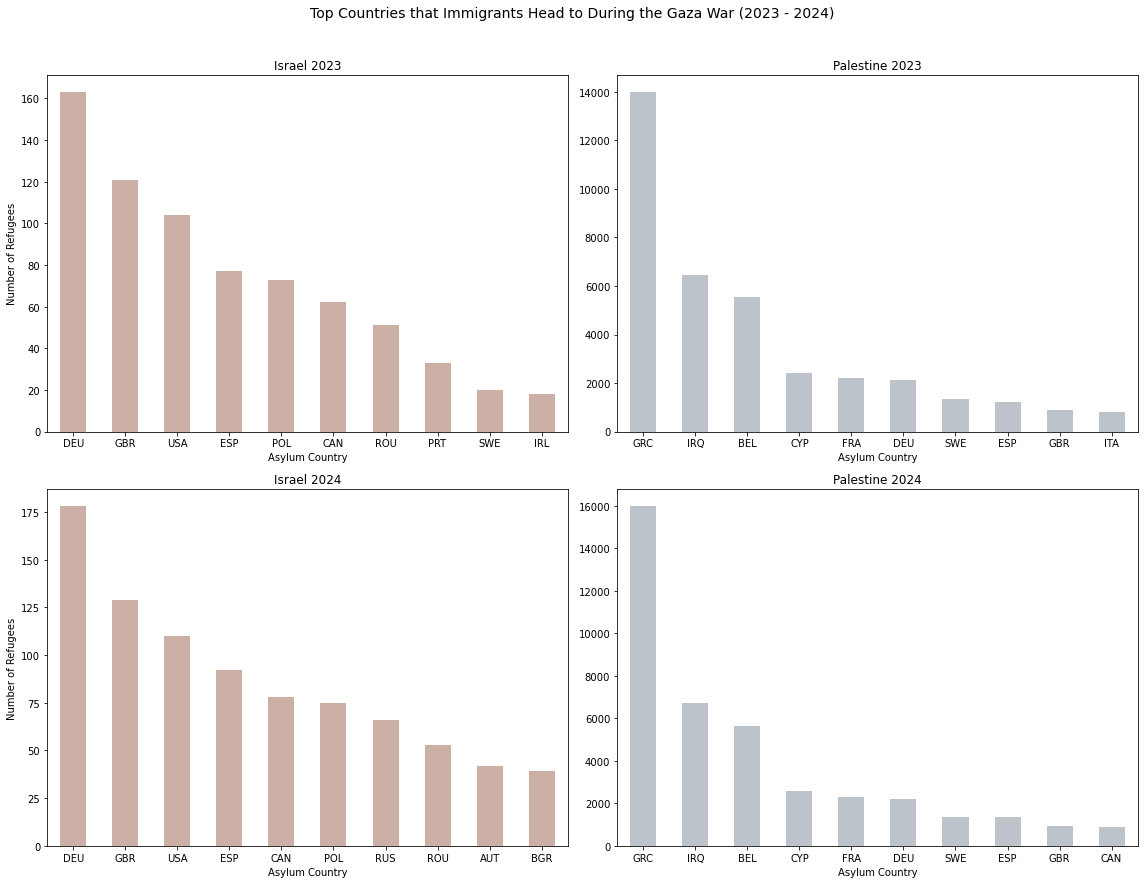

In [19]:
# Create a 2x2 grid for side-by-side year comparisons
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2023 Data
df_2023_isr[:10].plot.bar(x='coa_iso', y='refugees', ax=axes[0, 0], legend=False, color = "#CCAFA5")
df_2023_pse[:10].plot.bar(x='coa_iso', y='refugees', ax=axes[0, 1], legend=False, color = "#BDC3CB")

# 2024 Data
df_2024_isr[:10].plot.bar(x='coa_iso', y='refugees', ax=axes[1, 0], legend=False, color = "#CCAFA5")
df_2024_pse[:10].plot.bar(x='coa_iso', y='refugees', ax=axes[1, 1], legend=False, color = "#BDC3CB")

# Formatting
for row, year in enumerate([2023, 2024]):
    for col, country in enumerate(['Israel', 'Palestine']):
        axes[row,col].set_title(f"{country} {year}")
        axes[row,col].tick_params(axis='x', rotation=0)
        axes[row,col].set_xlabel('Asylum Country')
        if col == 0:
            axes[row,col].set_ylabel('Number of Refugees')

plt.suptitle("Top Countries that Immigrants Head to During the Gaza War (2023 - 2024)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [20]:
#number of refugess
print("Total number of refugees\n")

print(" -- 2023 -- ")
print(f"Israel: {df_2023_isr['refugees'].sum()}")
print(f"Palestine: {df_2023_pse['refugees'].sum()}")


print("\n -- 2024 -- ")
print(f"Israel: {df_2024_isr['refugees'].sum()}")
print(f"Palestine: {df_2024_pse['refugees'].sum()}")

Total number of refugees

 -- 2023 -- 
Israel: 855
Palestine: 41077

 -- 2024 -- 
Israel: 1056
Palestine: 44513


Note how Palestinian immigrants are greater than the number of immigrants in Israel -- would this indicate the different situation within each country?